# Rakuten Image Classification - Swin Transformer

## 1. Model Definition

In [1]:
import torch
import torch.nn as nn
import timm
from typing import Optional

class RakutenSwin(nn.Module):
    """
    Swin Transformer for Rakuten product classification.
    
    Uses swin_base_patch4_window7_224 backbone with custom classification head.
    """
    
    def __init__(
        self,
        model_name: str = 'swin_base_patch4_window7_224',
        num_classes: int = 27,
        pretrained: bool = True
    ):
        super(RakutenSwin, self).__init__()
        
        self.backbone = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=0,
            global_pool='avg',
            drop_path_rate=0.3
        )
        
        feature_dim = self.backbone.num_features
        
        self.head = nn.Sequential(
            nn.LayerNorm(feature_dim),
            nn.Dropout(p=0.5),
            nn.Linear(feature_dim, num_classes)
        )
        
        self.num_classes = num_classes
        self.model_name = model_name
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.backbone(x)
        logits = self.head(features)
        return logits

print("RakutenSwin class defined")

RakutenSwin class defined


## 2. Model Verification

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

model = RakutenSwin(num_classes=27, pretrained=True)
model = model.to(device)

print(f"\nModel: {model.model_name}")
print(f"Classes: {model.num_classes}")
print(f"Feature dim: {model.backbone.num_features}")

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

dummy_input = torch.randn(2, 3, 224, 224).to(device)
with torch.no_grad():
    output = model(dummy_input)

print(f"\nInput shape: {dummy_input.shape}")
print(f"Output shape: {output.shape}")
assert output.shape == (2, 27), f"Expected shape (2, 27), got {output.shape}"
print("✓ Verification passed")

Device: cuda

Model: swin_base_patch4_window7_224
Classes: 27
Feature dim: 1024

Total parameters: 86,772,947
Trainable parameters: 86,772,947

Input shape: torch.Size([2, 3, 224, 224])
Output shape: torch.Size([2, 27])
✓ Verification passed


## 3. Training Setup

In [3]:
import sys
import os
from pathlib import Path
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, f1_score
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.cuda.amp import GradScaler
import wandb

project_root = Path.cwd().parent.parent
scripts_dir = project_root / "scripts"
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
if str(scripts_dir) not in sys.path:
    sys.path.insert(0, str(scripts_dir))

from src.rakuten_image.datasets import RakutenImageDataset
from load_data import split_data

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

wandb.login()

PyTorch version: 2.5.1+cu121
CUDA available: True
GPU: NVIDIA GeForce RTX 3060 Ti


wandb: Currently logged in as: xiaosong-dev (xiaosong-dev-formation-data-science) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
CONFIG = {
    "data_dir": Path("/workspace/data"),
    "img_dir": Path("/workspace/data/images/image_train"),
    "checkpoint_dir": Path("/workspace/checkpoints/swin_production"),

    "model_name": "swin_base_patch4_window7_224",
    "img_size": 224,
    "batch_size": 32,
    "num_epochs": 10,
    "learning_rate": 5e-5,
    "weight_decay": 0.1,

    "val_split": 0.15,
    "random_state": 42,
    "early_stopping_patience": 5,

    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "num_workers": 4,
    "use_amp": True,
}

print("=" * 80)
print("Swin Transformer Production Training")
print("=" * 80)
print(f"Device: {CONFIG['device']}")
print(f"Model: {CONFIG['model_name']}")
print(f"Batch size: {CONFIG['batch_size']}")
print(f"Epochs: {CONFIG['num_epochs']}")
print(f"Learning rate: {CONFIG['learning_rate']}")
print(f"Weight decay: {CONFIG['weight_decay']}")
print(f"AMP: {CONFIG['use_amp']}")
print("=" * 80)

Swin Transformer Production Training
Device: cuda
Model: swin_base_patch4_window7_224
Batch size: 32
Epochs: 10
Learning rate: 5e-05
Weight decay: 0.1
AMP: True


## 4. Data Loading

In [5]:
X_dev, X_holdout, y_dev, y_holdout = split_data()

df_dev = X_dev.copy()
df_dev['prdtypecode'] = y_dev

df_holdout = X_holdout.copy()
df_holdout['prdtypecode'] = y_holdout

print(f"Development: {len(df_dev):,} samples")
print(f"Hold-out: {len(df_holdout):,} samples")
print(f"Classes: {df_dev['prdtypecode'].nunique()}")

Development: 72,178 samples
Hold-out: 12,738 samples
Classes: 27


In [6]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
all_labels = pd.concat([df_dev['prdtypecode'], df_holdout['prdtypecode']])
label_encoder.fit(all_labels)

df_dev['encoded_label'] = label_encoder.transform(df_dev['prdtypecode'])
df_holdout['encoded_label'] = label_encoder.transform(df_holdout['prdtypecode'])

num_classes = len(label_encoder.classes_)
print(f"Encoded classes: {num_classes}")
assert num_classes == 27

Encoded classes: 27


In [7]:
missing_images_dev = []
for idx, row in df_dev.iterrows():
    imageid = int(row['imageid'])
    productid = int(row['productid'])
    img_path = CONFIG["img_dir"] / f"image_{imageid}_product_{productid}.jpg"
    if not img_path.exists():
        missing_images_dev.append(idx)

if missing_images_dev:
    df_dev = df_dev.drop(missing_images_dev)

missing_images_holdout = []
for idx, row in df_holdout.iterrows():
    imageid = int(row['imageid'])
    productid = int(row['productid'])
    img_path = CONFIG["img_dir"] / f"image_{imageid}_product_{productid}.jpg"
    if not img_path.exists():
        missing_images_holdout.append(idx)

if missing_images_holdout:
    df_holdout = df_holdout.drop(missing_images_holdout)

print(f"After cleaning - Dev: {len(df_dev):,}, Hold-out: {len(df_holdout):,}")

After cleaning - Dev: 72,178, Hold-out: 12,738


In [8]:
from sklearn.model_selection import train_test_split

train_indices, val_indices, _, _ = train_test_split(
    df_dev.index,
    df_dev['encoded_label'],
    test_size=0.15,
    random_state=CONFIG["random_state"],
    stratify=df_dev['encoded_label']
)

df_train = df_dev.loc[train_indices].reset_index(drop=True)
df_val = df_dev.loc[val_indices].reset_index(drop=True)
df_holdout = df_holdout.reset_index(drop=True)

print(f"Training: {len(df_train):,}")
print(f"Validation: {len(df_val):,}")
print(f"Hold-out: {len(df_holdout):,}")

Training: 61,351
Validation: 10,827
Hold-out: 12,738


In [9]:
train_transform = transforms.Compose([
    transforms.Resize((CONFIG["img_size"], CONFIG["img_size"])),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((CONFIG["img_size"], CONFIG["img_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = RakutenImageDataset(
    dataframe=df_train,
    image_dir=CONFIG["img_dir"],
    transform=train_transform,
    label_col="encoded_label"
)

val_dataset = RakutenImageDataset(
    dataframe=df_val,
    image_dir=CONFIG["img_dir"],
    transform=val_transform,
    label_col="encoded_label"
)

test_dataset = RakutenImageDataset(
    dataframe=df_holdout,
    image_dir=CONFIG["img_dir"],
    transform=val_transform,
    label_col="encoded_label"
)

train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=True,
    num_workers=CONFIG["num_workers"],
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    num_workers=CONFIG["num_workers"],
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    num_workers=CONFIG["num_workers"],
    pin_memory=True
)

print(f"Train batches: {len(train_loader):,}")
print(f"Val batches: {len(val_loader):,}")
print(f"Test batches: {len(test_loader):,}")

Pre-loading paths into memory...
Dataset initialized with 61351 samples.
Pre-loading paths into memory...
Dataset initialized with 10827 samples.
Pre-loading paths into memory...
Dataset initialized with 12738 samples.
Train batches: 1,917
Val batches: 339
Test batches: 399


## 5. Model Initialization

In [10]:
model = RakutenSwin(
    model_name=CONFIG["model_name"],
    num_classes=num_classes,
    pretrained=True
)
model = model.to(CONFIG["device"])

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 86,772,947
Trainable parameters: 86,772,947


In [11]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=CONFIG["learning_rate"],
    weight_decay=CONFIG["weight_decay"]
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=CONFIG["num_epochs"]
)

scaler = torch.amp.GradScaler('cuda') if CONFIG["use_amp"] else None

CONFIG["checkpoint_dir"].mkdir(parents=True, exist_ok=True)

with open(CONFIG["checkpoint_dir"] / "config.json", "w") as f:
    json.dump({k: str(v) for k, v in CONFIG.items()}, f, indent=2)

print("Optimizer: AdamW with Cosine Annealing")
print(f"Checkpoint dir: {CONFIG['checkpoint_dir']}")

Optimizer: AdamW with Cosine Annealing
Checkpoint dir: /workspace/checkpoints/swin_production


## 6. Training Loop

In [12]:
wandb.init(
    project="rakuten-classification",
    entity="xiaosong-dev-formation-data-science",
    config=CONFIG,
    name="experiment_1_baseline_overfit",
    notes="Baseline run: Standard params, expected to overfit"
)

best_val_acc = 0.0
best_val_loss = float('inf')
best_val_f1 = 0.0
patience_counter = 0
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
    "val_f1": []
}

def update_plots():
    clear_output(wait=True)
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    
    axes[0].plot(history["train_loss"], label='Train Loss', marker='o', linewidth=2)
    axes[0].plot(history["val_loss"], label='Val Loss', marker='s', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(history["train_acc"], label='Train Acc', marker='o', linewidth=2)
    axes[1].plot(history["val_acc"], label='Val Acc', marker='s', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Best Val Acc: {best_val_acc:.2f}% | F1: {best_val_f1:.4f} (Patience: {patience_counter}/{CONFIG['early_stopping_patience']})")

print("=" * 80)
print("Starting Training")
print("=" * 80)

Starting Training


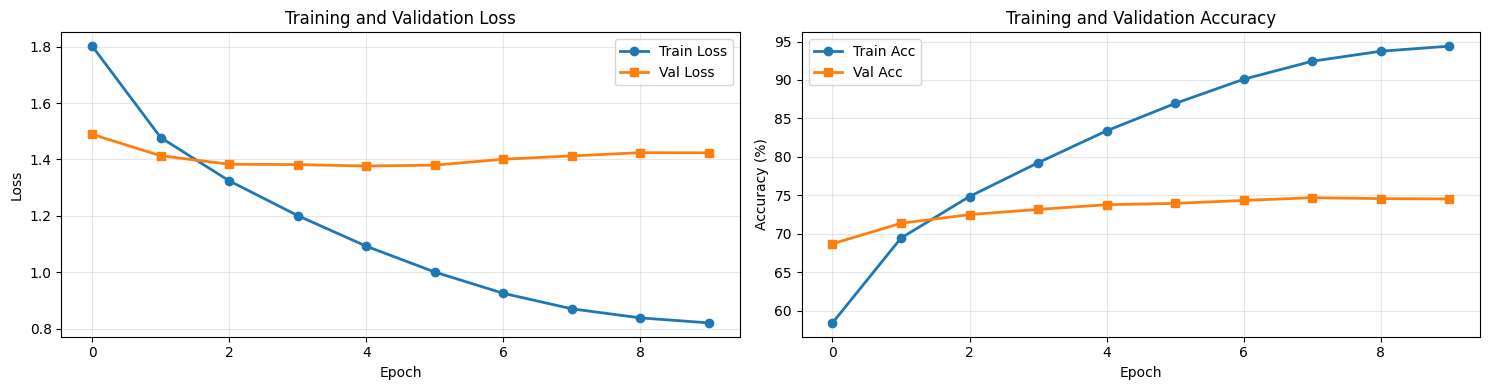

Best Val Acc: 74.69% | F1: 0.7436 (Patience: 2/5)
Training Complete


In [13]:
for epoch in range(CONFIG["num_epochs"]):
    print(f"\nEpoch {epoch + 1}/{CONFIG['num_epochs']}")
    print("=" * 80)
    
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    train_pbar = tqdm(train_loader, desc="Training")
    for images, labels in train_pbar:
        images, labels = images.to(CONFIG["device"]), labels.to(CONFIG["device"])
        
        optimizer.zero_grad()
        
        if CONFIG["use_amp"]:
            with torch.amp.autocast(device_type="cuda"):
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        
        train_loss += loss.item()
        predictions = torch.argmax(outputs, dim=-1)
        train_correct += (predictions == labels).sum().item()
        train_total += labels.size(0)
        
        train_pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.0 * train_correct / train_total:.2f}%'
        })
    
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100.0 * train_correct / train_total
    
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    # Collect predictions and labels for F1 score
    all_val_preds = []
    all_val_labels = []
    
    val_pbar = tqdm(val_loader, desc="Validation")
    with torch.no_grad():
        for images, labels in val_pbar:
            images, labels = images.to(CONFIG["device"]), labels.to(CONFIG["device"])
            
            if CONFIG["use_amp"]:
                with torch.amp.autocast(device_type="cuda"):
                    outputs = model(images)
                    loss = criterion(outputs, labels)
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            predictions = torch.argmax(outputs, dim=-1)
            val_correct += (predictions == labels).sum().item()
            val_total += labels.size(0)
            
            # Collect for F1 score
            all_val_preds.extend(predictions.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())
            
            val_pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.0 * val_correct / val_total:.2f}%'
            })
    
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100.0 * val_correct / val_total
    
    # Calculate F1 score
    val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')
    
    history["train_loss"].append(avg_train_loss)
    history["train_acc"].append(train_accuracy)
    history["val_loss"].append(avg_val_loss)
    history["val_acc"].append(val_accuracy)
    history["val_f1"].append(val_f1)
    
    # WandB logging with F1 score
    wandb.log({
        "train_loss": avg_train_loss,
        "train_acc": train_accuracy,
        "val_loss": avg_val_loss,
        "val_acc": val_accuracy,
        "val_f1": val_f1,
        "epoch": epoch + 1,
        "learning_rate": optimizer.param_groups[0]['lr']
    })
    
    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}%")
    print(f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}% | F1: {val_f1:.4f}")
    
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        best_val_loss = avg_val_loss
        best_val_f1 = val_f1
        patience_counter = 0
        
        checkpoint_path = CONFIG["checkpoint_dir"] / "best_model.pth"
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'scaler_state_dict': scaler.state_dict() if CONFIG["use_amp"] else None,
            'val_acc': val_accuracy,
            'val_loss': avg_val_loss,
            'val_f1': val_f1,
            'train_acc': train_accuracy,
            'train_loss': avg_train_loss,
        }, checkpoint_path)
        
        print(f"Best model saved! (Val Acc: {val_accuracy:.2f}%, F1: {val_f1:.4f})")
    else:
        patience_counter += 1
        print(f"No improvement ({patience_counter}/{CONFIG['early_stopping_patience']})")
    
    scheduler.step()
    update_plots()
    
    if patience_counter >= CONFIG["early_stopping_patience"]:
        print(f"Early stopping triggered after {epoch + 1} epochs")
        break

print("=" * 80)
print("Training Complete")
print("=" * 80)

## 7. Final Evaluation

In [14]:
checkpoint = torch.load(CONFIG["checkpoint_dir"] / "best_model.pth", weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Best model from epoch {checkpoint['epoch']}")
print(f"Val Accuracy: {checkpoint['val_acc']:.2f}%")

Best model from epoch 8
Val Accuracy: 74.69%


In [15]:
all_preds_val = []
all_labels_val = []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Validation"):
        images = images.to(CONFIG["device"])
        
        if CONFIG["use_amp"]:
            with torch.amp.autocast(device_type="cuda"):
                outputs = model(images)
        else:
            outputs = model(images)
            
        predictions = torch.argmax(outputs, dim=-1)
        all_preds_val.extend(predictions.cpu().numpy())
        all_labels_val.extend(labels.numpy())

val_acc_final = accuracy_score(all_labels_val, all_preds_val)
print(f"Validation Accuracy: {val_acc_final*100:.2f}%")

Validation: 100%|██████████| 339/339 [00:26<00:00, 12.93it/s]

Validation Accuracy: 74.69%


In [16]:
all_preds_test = []
all_labels_test = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Hold-out Test"):
        images = images.to(CONFIG["device"])
        
        if CONFIG["use_amp"]:
            with torch.amp.autocast(device_type="cuda"):
                outputs = model(images)
        else:
            outputs = model(images)
            
        predictions = torch.argmax(outputs, dim=-1)
        all_preds_test.extend(predictions.cpu().numpy())
        all_labels_test.extend(labels.numpy())

test_acc_final = accuracy_score(all_labels_test, all_preds_test)
print(f"Hold-out Test Accuracy: {test_acc_final*100:.2f}%")

print("\n" + "=" * 80)
print("Classification Report (Hold-out Test)")
print("=" * 80)
print(classification_report(all_labels_test, all_preds_test, digits=4, zero_division=0))

Hold-out Test: 100%|██████████| 399/399 [00:30<00:00, 12.96it/s]

Hold-out Test Accuracy: 74.73%

Classification Report (Hold-out Test)
              precision    recall  f1-score   support

           0     0.6894    0.7794    0.7317       467
           1     0.7199    0.7314    0.7256       376
           2     0.6639    0.6349    0.6491       252
           3     0.8158    0.7440    0.7782       125
           4     0.7425    0.7406    0.7416       401
           5     0.9532    0.9612    0.9572       593
           6     0.6042    0.5043    0.5498       115
           7     0.5136    0.4637    0.4874       731
           8     0.4644    0.4405    0.4521       311
           9     0.7632    0.8428    0.8010       757
          10     0.8720    0.9008    0.8862       121
          11     0.5989    0.5668    0.5824       374
          12     0.6721    0.5988    0.6333       486
          13     0.6865    0.6505    0.6680       761
          14     0.8402    0.8870    0.8630       646
          15     0.8099    0.8167    0.8133       120
          1

In [17]:
history_path = CONFIG["checkpoint_dir"] / "training_history.json"
with open(history_path, "w") as f:
    json.dump(history, f, indent=2)

results = {
    "best_epoch": int(checkpoint['epoch']),
    "val_acc": float(checkpoint['val_acc']),
    "final_val_acc": float(val_acc_final * 100),
    "final_test_acc": float(test_acc_final * 100),
    "num_classes": int(num_classes),
    "model": CONFIG["model_name"]
}

results_path = CONFIG["checkpoint_dir"] / "final_results.json"
with open(results_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"History saved: {history_path}")
print(f"Results saved: {results_path}")

History saved: /workspace/checkpoints/swin_production/training_history.json
Results saved: /workspace/checkpoints/swin_production/final_results.json


## 8. Visualizations

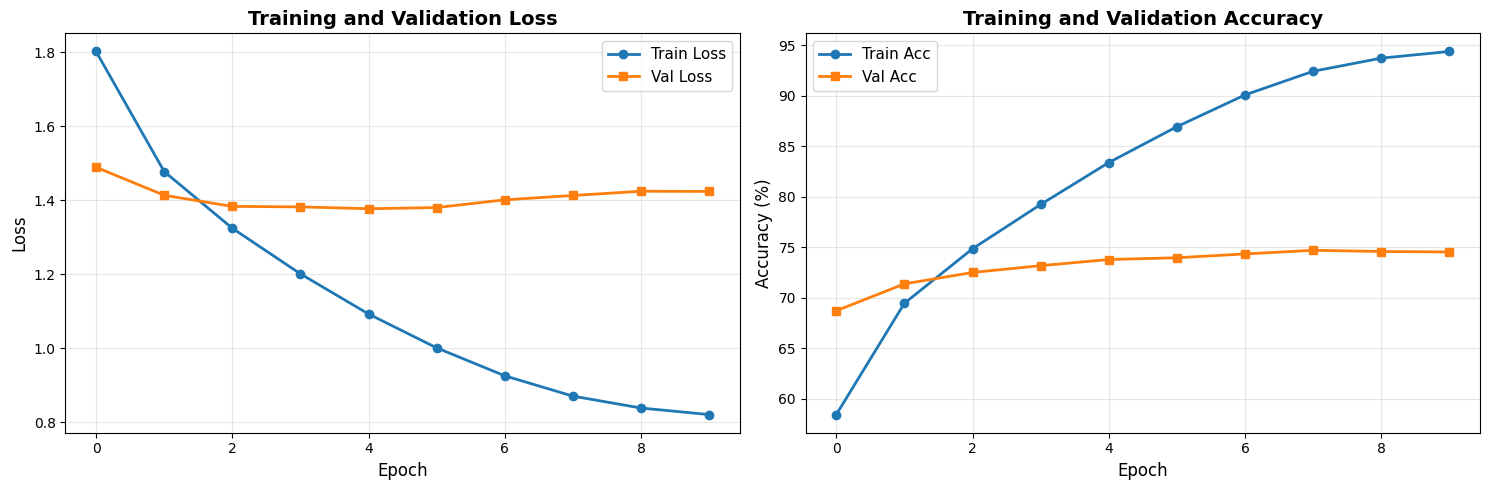

Plot saved: /workspace/checkpoints/swin_production/training_curves.png


In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history["train_loss"], label='Train Loss', marker='o', linewidth=2)
axes[0].plot(history["val_loss"], label='Val Loss', marker='s', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

axes[1].plot(history["train_acc"], label='Train Acc', marker='o', linewidth=2)
axes[1].plot(history["val_acc"], label='Val Acc', marker='s', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plot_path = CONFIG["checkpoint_dir"] / 'training_curves.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"Plot saved: {plot_path}")

## 9. Summary

In [19]:
print("=" * 80)
print("Training Summary")
print("=" * 80)
print(f"Model: {CONFIG['model_name']}")
print(f"Total samples: {len(df_train) + len(df_val) + len(df_holdout):,}")
print(f"Training: {len(train_dataset):,}")
print(f"Validation: {len(val_dataset):,}")
print(f"Hold-out: {len(test_dataset):,}")
print(f"Classes: {num_classes}")
print(f"\nBest epoch: {checkpoint['epoch']}")
print(f"Best val accuracy: {checkpoint['val_acc']:.2f}%")
print(f"Final val accuracy: {val_acc_final*100:.2f}%")
print(f"Final test accuracy: {test_acc_final*100:.2f}%")
print("=" * 80)

wandb.finish()

Training Summary
Model: swin_base_patch4_window7_224
Total samples: 84,916
Training: 61,351
Validation: 10,827
Hold-out: 12,738
Classes: 27

Best epoch: 8
Best val accuracy: 74.69%
Final val accuracy: 74.69%
Final test accuracy: 74.73%


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,██▇▇▆▄▃▂▂▁
train_acc,▁▃▄▅▆▇▇███
train_loss,█▆▅▄▃▂▂▁▁▁
val_acc,▁▄▅▆▇▇████
val_f1,▁▄▅▆▇▇████
val_loss,█▃▁▁▁▁▂▃▄▄
epoch,10
learning_rate,0.0
train_acc,94.3988
train_loss,0.82052
